# Deep Learning: Proof of Concept

### Deploying a Convolutional Neural Network for Image Classification with Watsonx.AI

<br>

In this notebook, we demonstrate the end-to-end process of a Convolutional Neural Network development from inception to deployment and testing.

#### What is a Convolutional Neural Network?

A **Convolutional Neural Network** (also known as **CNN**) is a type of deep learning model specifically designed for processing structured grid data like images, using convolutional layers to automatically extract features.

#### Use Cases

CNN models are particularly good at capturing spatial hierarchies in images to identify patterns, which makes them ideal for tasks such as image classification.

#### The Dataset

To demonstrate how a CNN works, we will use the **MNIST** Dataset.

This is a large dataset of handwritten digits, often used for demoing image classification with neural networks.

#### Model Deployment

ML model deployment refers to the process of taking a trained machine learning model and integrating it into a production environment where it can make predictions or decisions based on real-world data. 

Cloud deployment allows for scalable, accessible, and efficient use of models, providing high computational resources and enabling real-time inference and updates.

In other words, it makes the CNN we will develop usable.

In this scenario, we will deploy the model on IBM Cloud. IBM watonx.ai is a solution that provides an API to store and deploy models on cloud via interface or programmatically. 

Due to the entity of the exercise, we will be deploying the model using the SDK to make API inferences on watsonx.ai (programmatic approach).

## 1. Importing Libraries

The following libraries will allow us to:

- Load and read the mnist dataset
- Perform some exploratory analysis
- Create convolutional neural networks using Keras sequential models
- Add optimizers
- Facilitate the process of visualization of images and results

In [155]:
# importing required libraries
import numpy as np
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import to_categorical
import keras

## 2. Data Preparation

### 2.1 Load the Dataset

In [145]:
# loading mist handwritten dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### 2.2 Exploratory Analysis

#### Visualize a Data Sample: the Target

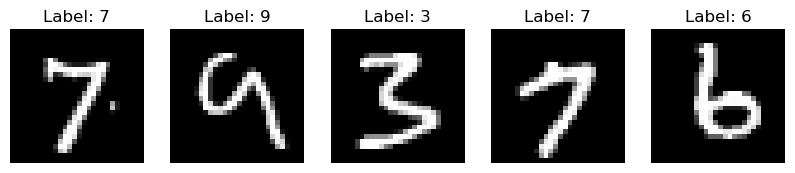

In [147]:
# Load 5 random images from the training set
random_indices = np.random.choice(X_train.shape[0], 5, replace=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.show()

#### Distribution of the target

The MNIST dataset contains images of digits from 0 to 9.

First, we want to verify that the dataset contains an even distribution of the classes (i.e. the 0-9 digits).

Second, we want to verify that the distribution of each digits in the train and test set is more or less the same.

##### Why we do this:

- On training, it minimizes bias, so predictions are more fair
- On testing, it allows for random testing where each digit has the same chance of being picked.

In [176]:
# Check the distribution of labels in y_train and y_test
train_label_distribution = dict(Counter(y_train))
test_label_distribution = dict(Counter(y_test))

print("Train Label Distribution:", train_label_distribution)
print("Test Label Distribution:", test_label_distribution)


Train Label Distribution: {5: 5421, 0: 5923, 4: 5842, 1: 6742, 9: 5949, 2: 5958, 3: 6131, 6: 5918, 7: 6265, 8: 5851}
Test Label Distribution: {7: 1028, 2: 1032, 1: 1135, 0: 980, 4: 982, 9: 1009, 5: 892, 6: 958, 3: 1010, 8: 974}


In [177]:
# Total size of datasets
total_train = len(y_train)
total_test = len(y_test)
total_data = total_train + total_test

# Create dataframes to report the counts and percentages for y_train
train_data = {
    'Label': list(train_label_distribution.keys()),
    'Count (Train)': list(train_label_distribution.values()),
    '% Train': [round(count / total_train * 100, 2) for count in train_label_distribution.values()],
    '%rel train': [round(count / total_data * 100, 2) for count in train_label_distribution.values()]
}

# Create dataframes to report the counts and percentages for y_test
test_data = {
    'Label': list(test_label_distribution.keys()),
    'Count (Test)': list(test_label_distribution.values()),
    '% Test': [round(count / total_test * 100,2) for count in test_label_distribution.values()],
    '%rel Test ': [round(count / total_data * 100,2) for count in test_label_distribution.values()]
}

x1_stats = pd.DataFrame(train_data)
x2_stats = pd.DataFrame(test_data)
stats = pd.merge(x1_stats, x2_stats, on='Label', how='left').sort_values(by='Label').set_index('Label')
stats

,Count (Train),% Train,%rel train,Count (Test),% Test,%rel Test
Label,,,,,,
0,5923,9.87,8.46,980,9.80,1.40
1,6742,11.24,9.63,1135,11.35,1.62
2,5958,9.93,8.51,1032,10.32,1.47
3,6131,10.22,8.76,1010,10.10,1.44
4,5842,9.74,8.35,982,9.82,1.40
5,5421,9.04,7.74,892,8.92,1.27
6,5918,9.86,8.45,958,9.58,1.37
7,6265,10.44,8.95,1028,10.28,1.47
8,5851,9.75,8.36,974,9.74,1.39


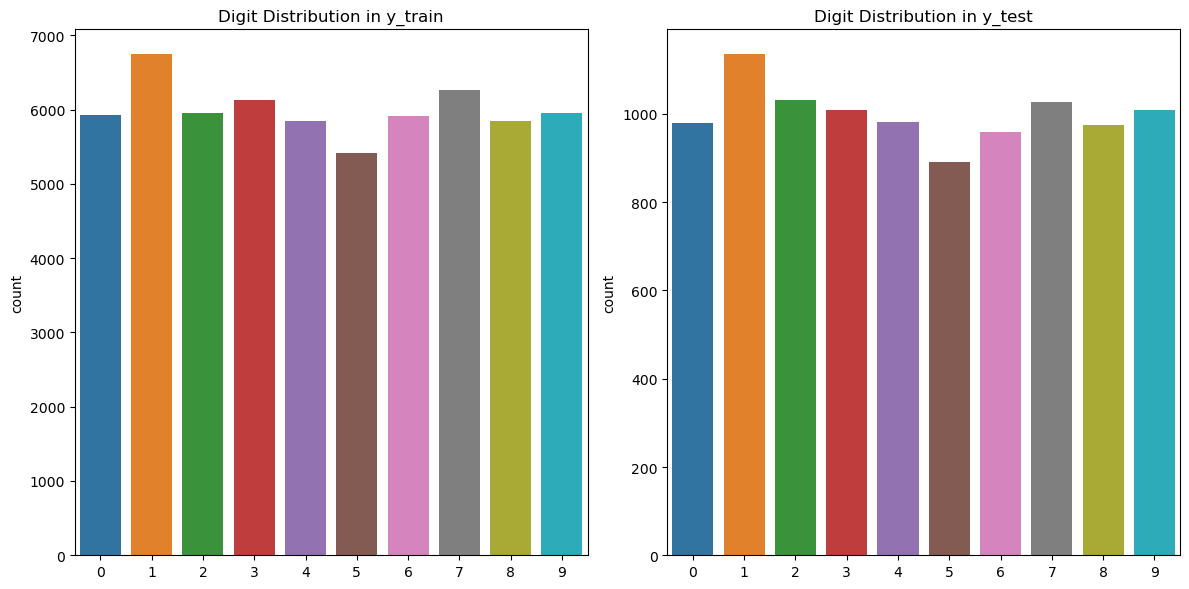

In [179]:
# Visualize on a plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Digit Distribution in y_train')
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Digit Distribution in y_test')

plt.tight_layout()
plt.show()

**We have an even distribution of the digits in both sets.**

#### Visualize a data sample: the features

We will have a look how a feature looks like in the dataset.

In [182]:
# The Shape
X_train[0].shape

(28, 28)

The output of `shape` method means that each image in the MNIST dataset is a 28x28 pixel grayscale image.

Also, we can infer without even opening an image, that the sample selected is in grayscale.

If the images were in color, they would typically have 3 channels (Red, Green, and Blue).

This would translate in a shape of (28, 28, 3), where 3 represents the 3 channels.

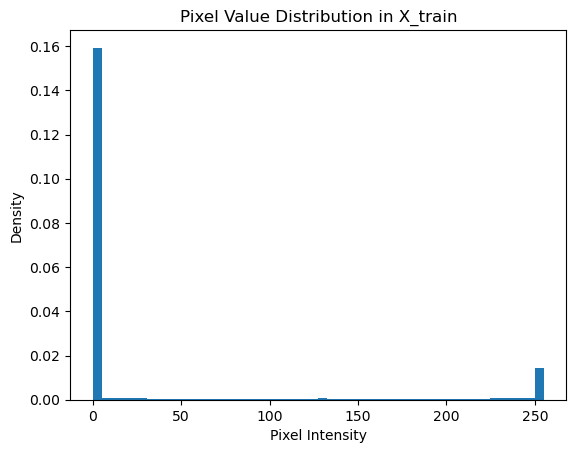

In [184]:
# Distribution of pixel values
plt.hist(X_train.flatten(), bins=50, range=(0, 255), density=True)
plt.title('Pixel Value Distribution in X_train')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.show()


#### Explaining the value distribution

- **Value 0**: This corresponds to <u>black pixels</u>. 
- **Value 250**: This corresponds to <u>white pixels</u>. 

The most populated bins are at the extremes, validating the assumption we are handling images in grayscale. 

In the MNIST dataset, the pixels representing the foreground (the digits themselves) are likely bright white in some parts of the image.

This may explain why we have 2 smaller bins (one just after bin at value 0 and before bin at value 250). These could represent **shades of gray** in the image.

We will minimize this *noise* during the data preprocessing phase.

In [185]:
# Correlation between pixel intensity
sample_image = X_train[0].flatten()  # Flattening the image into 1D
corr_matrix = np.corrcoef(sample_image)  # For simplicity, using one image
print(corr_matrix)

1.0


#### Explaining the perfect correlation

We have a correlation = 1.

This suggests that pixel intensities in the image are very uniform or exhibit a consistent pattern, (either row-wise, column-wise, or across the entire image).

In our case, we know that the image have very little variation in pixel values, because are grayscaled.

The correlation simply states that the black and white pixels follow a specific pattern. When opening an image, we see that:

- black pixels correspond to background
- white pixels correspond to digits

### 2.3 Preprocess Data

In this step we prepare the data before feeding it to a neural network in training.

We will perform three operations:

1. thresholding (removes noise)
2. reshaping (provide consistent shape for training)
3. one-hot encoding (transforms target variable in oh-encoded lists)

#### Thresholding

Thresholding is a simple but effective technique for binarizing an image—converting it into black and white.

- Each pixel intensity is compared to a threshold (127 in this case).
- If the pixel intensity is greater than 127, it is set to 255 (white).
- If the pixel intensity is less than or equal to 127, it is set to 0 (black).

This way we achieve a high contrasting image, where small variations in pixel intensity (which may be due to noise) are eliminated.

In [4]:
# Applying threshold for removing noise 
_, X_train_th = cv2.threshold(X_train,127,255,cv2.THRESH_BINARY)
_, X_test_th = cv2.threshold(X_test,127,255,cv2.THRESH_BINARY)

#### Reshaping

We give the data the right shape for a convolutional neural network:

In [5]:
# Reshaping
X_train = X_train_th.reshape(-1,28,28,1)
X_test = X_test_th.reshape(-1,28,28,1)

#### Redefine categorical classes

Neural Networks do not work well with raw categorical labels (e.g., {0, 1, 2, ..., 9}). 

Instead, they require labels in a numerical format that avoids unintended ordinal relationships.

So we one-hot encode each label.

Each label is converted into a binary vector with 10 positions (labels go from 0 to 9).

##### For a label whose original value was 4, vector will be:

    [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]

In [186]:
# Creating categorical output from 0 to 9
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [187]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 2.4 Check if input and output size match transformations

In [188]:
# cross checking shape of input and output
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000, 10)
(10000, 28, 28) (10000, 10)


## 3. Create the Neural Network

In this section we create a baseline neural network that uses convolutional layers. The architecture of the CNN is hereby explained:

#### - Convolutional Layers

Those layers are specific to CNN. They use kernels, or filters, that are used to scan the image for specific features (edges, corners, etc).

All Conv2D layers will use `relu` as activation to introduce non-linearity, for the sake of learning more complex patterns.

The **The first convolutional layer** also contains the input shape, because this is the layer that initiates the learning process.

#### - Pooling Layer

The second convolutional layer is followed by a MaxPool2D layer.

Notice that the 2nd conv. layer has higher depth (from 32 in initial kernel to 64) of feature detection, allowing the model to capture more complex patterns.

That's why we use the pooling layer: it reduces the computational load by downsampling the feature maps of the image.

#### - DropOut

Dropout is a regularization technique that prevents overfitting by ensuring that the model does not rely too heavily on any single neuron.

The dropout layer layer randomly drops 25% of the neurons during training.


#### - Flattening

Flattening is required to convert this output into a single vector that can be fed into fully connected (Dense) layers for final classification.


#### - Dense Layer

This fully connected layer contains 128 neurons and uses `relu` to capture complex relationships.


#### - Output Layer

This final layer is needed to perform the classification task. 

The `softmax` activation function converts the raw output values into a probability distribution. 

The probability distribution value is responsible for assigning the most probable class to that line of training data, thus ensuring predictions are done accordingly.

### 3.1 Define the CNN

In [14]:
# Params
input_shape = (28,28,1)
number_of_classes = 10


# Instantiate the sequential model
model = Sequential()

# First convolutional layer (contains input shape)
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))

# Second conv. layer + maxpool
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Dropout layer
model.add(Dropout(0.25))

# Flatten + Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Flatten + Dense Layers w. softmax for output
model.add(Dropout(0.5))
model.add(Dense(number_of_classes, activation='softmax'))

In [15]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                      

### 3.2 Train the CNN

In [16]:
# compiling the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [17]:
# Fit the model
history = model.fit(X_train, y_train,epochs=10, shuffle=True,
                    batch_size = 200,validation_data= (X_test, y_test))

Epoch 1/10
300/300 [==============================] - 125s 414ms/step - loss: 37.4549 - accuracy: 0.1227 - val_loss: 7.9345 - val_accuracy: 0.2867
Epoch 2/10
300/300 [==============================] - 124s 414ms/step - loss: 19.2304 - accuracy: 0.2127 - val_loss: 3.3422 - val_accuracy: 0.5067
Epoch 3/10
300/300 [==============================] - 124s 412ms/step - loss: 11.0192 - accuracy: 0.2873 - val_loss: 1.8599 - val_accuracy: 0.5822
Epoch 4/10
300/300 [==============================] - 118s 394ms/step - loss: 6.8258 - accuracy: 0.3267 - val_loss: 1.3843 - val_accuracy: 0.5841
Epoch 5/10
300/300 [==============================] - 124s 413ms/step - loss: 4.4749 - accuracy: 0.3395 - val_loss: 1.3687 - val_accuracy: 0.5460
Epoch 6/10
300/300 [==============================] - 123s 409ms/step - loss: 3.1976 - accuracy: 0.3345 - val_loss: 1.4919 - val_accuracy: 0.5000
Epoch 7/10
300/300 [==============================] - 121s 404ms/step - loss: 2.5743 - accuracy: 0.3333 - val_loss: 1.575

### 3.3 Evaluate CNN performance

#### General Accuracy of Classification

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 [==============================] - 6s 18ms/step - loss: 1.5599 - accuracy: 0.5336
Test Accuracy: 0.5336


#### Model performance on single observation

In [19]:
predictions = model.predict(X_test)  # Outputs probabilities
predicted_labels = predictions.argmax(axis=1)  # Get class with highest probability

# Reconvert y values to OG (were OH-encoded before)
true_labels = y_test.argmax(axis=1)

313/313 [==============================] - 6s 17ms/step


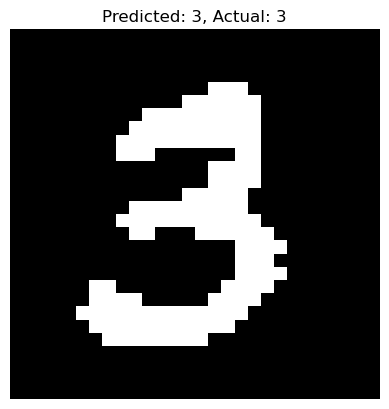

In [21]:
# Select a random test image
index = np.random.randint(len(X_test))
plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {predicted_labels[index]}, Actual: {true_labels[index]}")
plt.axis('off')
plt.show()

#### Model Training Performance

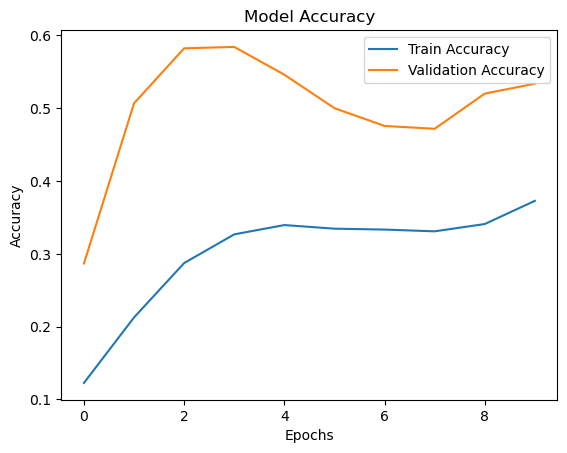

In [22]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

#### This model underfits.

The training accuracy (blue line) is quite low, staying below 0.35 even after multiple epochs.

This means the model is struggling to learn from the training data.

The value of training accuracy should be higher than validation accuracy, but here, validation accuracy is higher in early epochs.

General accuracy of the model is of 0.5336, indicating poor performance too.

**We will propose an improved architecture.**

### 3.4 Improved CNN Architecture

In this subsection, we propose a new model. Here are the key differences:

#### - Padding

- In the first model, we did not configure padding for Conv2D layers.
- The new model specifies the `padding` parameter (=same).

This means that the input and output enter a convolutional layer, their spatial dimensions (height and width) will be the same after the convolution operation.

#### - Batch Normalization

- The first model does not use Batch Normalization.
- In the second model, Batch Normalization is used after each convolutional layer.

This technique is used to make the training more stable. It normalizes the activations of the neurons after each convolution operation.

#### - Network Depth

- The first network had 2 convolutional layers: one with 32 and another with 64 kernels
- The second model has 3 convolutional blocks, each with increasingly filter sizes (32, 64, 128)

This allow for a deeper pattern recognition.


#### - Convolutions

- The previous model had only one convolutional layer (excluding input layer).
- The new model has two conv2D layers per block.


#### - Dropout

- One dropout in first model.
- More dropouts in new model.

This strategy is to reduce overfitting after each convolution.


#### - Increased number of neurons

- The dense layer had 128 neuron in the first model
- In the new model, the n. neuron has been increased to 256

Again, this allow from learning more complexity.


#### - Output layer

The new model has a larger dense layer (256 neurons vs. 128), which means it has more capacity to learn complex patterns.

In [25]:
# Params
input_shape = (28, 28, 1)
number_of_classes = 10

# Model Architecture
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())  # Normalizes activations
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Less aggressive dropout early on

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3 (More depth)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # More dropout in deeper layers

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # Increased neurons
model.add(BatchNormalization())
model.add(Dropout(0.5))  # High dropout to reduce overfitting
model.add(Dense(number_of_classes, activation='softmax'))  # Output layer

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                      

In [26]:
# Compile Model
optimizer = Adam(learning_rate=0.001)  # Adaptive learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### Train model

In [27]:
history = model.fit(X_train, y_train, epochs=15, batch_size=128, 
                    validation_data=(X_test, y_test), shuffle=True)

Epoch 1/15
469/469 [==============================] - 306s 648ms/step - loss: 0.3117 - accuracy: 0.9048 - val_loss: 0.0481 - val_accuracy: 0.9846
Epoch 2/15
469/469 [==============================] - 307s 654ms/step - loss: 0.0806 - accuracy: 0.9751 - val_loss: 0.0391 - val_accuracy: 0.9866
Epoch 3/15
469/469 [==============================] - 304s 648ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.0350 - val_accuracy: 0.9886
Epoch 4/15
469/469 [==============================] - 305s 650ms/step - loss: 0.0483 - accuracy: 0.9854 - val_loss: 0.0291 - val_accuracy: 0.9904
Epoch 5/15
469/469 [==============================] - 298s 635ms/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.0267 - val_accuracy: 0.9917
Epoch 6/15
469/469 [==============================] - 299s 638ms/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.0268 - val_accuracy: 0.9915
Epoch 7/15
469/469 [==============================] - 299s 639ms/step - loss: 0.0350 - accuracy: 0.9888 - val_loss: 0.0241 -

#### Evaluate

In [28]:
# Accuracy score
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 [==============================] - 9s 29ms/step - loss: 0.0211 - accuracy: 0.9934
Test Accuracy: 0.9934


313/313 [==============================] - 9s 28ms/step


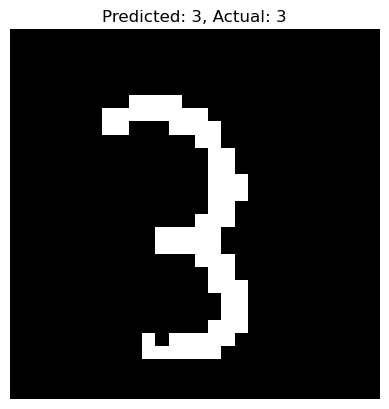

In [31]:
predictions = model.predict(X_test)  # Outputs probabilities
predicted_labels = predictions.argmax(axis=1)  # Get class with highest probability

# Reconvert y values to OG (were OH-encoded before)
true_labels = y_test.argmax(axis=1)

# Evaluate a random test image
index = np.random.randint(len(X_test))
plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {predicted_labels[index]}, Actual: {true_labels[index]}")
plt.axis('off')
plt.show()

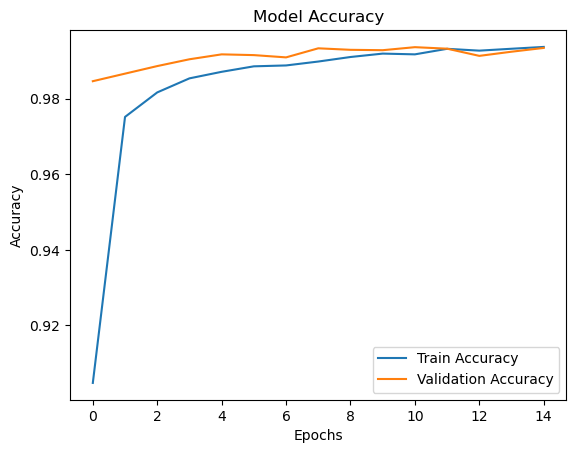

In [32]:
# Evaluate accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

- There is no significant gap between train and validation accuracy, which means minimal overfitting.
- Training beyond 10 epochs might not provide much additional benefit.
- The validation accuracy does not drop significantly at any point (model generalizes well on unseen data).

**We are satisfied with the model, therefore we will move on with deployment.**

<br>

### 3.5 Possible pitfalls of this CNN

We established that this Convolutional Neural Network performs excellently for the task it has been trained.

There are still several challenges that could be addressed before the model is put to production.

#### Overfitting

The new model is deeper, with more layers and neurons, which increases the model's capacity to memorize training data.

But this can lead to overfitting. It is important to try out the model with new data.

**Proposed Solutions**:

- *Early Stopping*. We saw that validation performance stopped improving after 10 epochs. We can use early stopping to stop training when validation performance stops improving.

- *Data Augmentation*. We can increase the training dataset (e.g., rotating, zooming, flipping images) to artificially increase the training dataset size.

#### Hyperparameter Tuning

Hyperparameters like learning rate, batch size, dropout rate, and number of filters need to be adjusted carefully.

In this scenario, hyperparameter optimization was not necessary. We tested a baseline and an improved architecture without actually trying out HPO.

The issue resides in the computational cost and time that *cross-search CV* and *grid-search CV* bring on the table.

In previous iteration where HPO was tested, the kernel died unexpectedly due to this issue.

**Proposed Solutions**:

- *other frameworks*. Optuna is another library that could be used to tune the model.

#### Vanishing Gradients

The new model is deeper, although we use regularization techniques the vanishing gradients problem may still occur.

In simpler model, the challenges related to the gradient are easier to mitigate.


#### Pitfalls from the dataset

The MNIST dataset contains images that, although diverse in their classes, are clean and simple. 

In real world, images do not come as clean as those. This may cause issue with "unseen scenario" when the model has to face images that are different from those of the MNIST dataset.

We could say that the model relies too much on the dataset. Currently, it does not seem to overfit.

**Proposed Solutions**:

- *adding new, diverse data*: we would need to retrain the model on other images
- *data agumentation and cross-validation*: those techniques could be introduced in future versions of the model

<br>



### 3.4 Transfer Learning as an option

In this scenario we demonstrated how to create a Convolutional Neural Network from scratch.

By increasing the complexity of the model, we heavily impacted the training time. 

Another option could have been using **transfer learning**.

We could initialize a *pre-trained* model (like VGG or ResNet), then we fine-tune it for MNIST. 

This should not significally reduce performance, but would definetely reduce the training time.

<br>

## 4. Store the model on Cloud

In this section, we will:

- prepare the model for storage, saving it in a compatible format
- connect to watsonx.ai runtime (ex watson machine learning) and set a deployment space where the model will be stored
- provide technical software specifications that will allow the model to work once deployed
- store the model

### 4.1 Compress the model

We will proceed to compress our neural network in `h5` format.

Then we will package it as `tgz`.

We do this to store the CNN's weights efficiently and to reduce file size.

At this point the model is also saved locally, which makes it easier to share if you are working on local environments.

In [76]:
# saving the model
model.save("digit_classifier.h5")

In [77]:
# convert model to .tar
!tar -zcvf digit_classification_model.tgz "digit_classifier.h5"

digit_classifier.h5


### 4.2 Set Deployment Space

On watsonx.ai, a deployment space is a dedicated environment where machine learning models, datasets, and other assets are stored, managed, and deployed for production use.

We connect to the deployment space from our current environment to transfer the model to its final environment.

In [78]:
from ibm_watsonx_ai import APIClient, Credentials

In [79]:
print('Connecting to watsonx.ai runtime instance... ')

credentials = Credentials(
    url = "https://eu-de.ml.cloud.ibm.com",
    api_key = "ENTER YOUR API KEY HERE",
)

client = APIClient(credentials)

print('Done')

client.spaces.list()

Connecting to watsonx.ai runtime instance... 
Done


,ID,NAME,CREATED
0,56aff6a7-532c-447a-9f09-0fd32e003ed8,cnn deployments,2025-02-14T12:42:26.886Z
1,e6aeac95-5bfa-4b78-87e7-f233194f2b17,NETI Deployment Space,2025-01-20T11:45:42.863Z


In [80]:
# Set deployment space id 
SPACE_ID = 'ENTER YOUR SPACE ID HERE'

client.set.default_space(SPACE_ID)

'SUCCESS'

### 4.3 Store the model on watson studio runtime (ex watson machine learning)

In [81]:
# Check specifications for the CNN (keras)
sw_spec = client.software_specifications.list()
sw_spec[sw_spec['NAME'].str.contains('tensorflow', case=False, na=False)].head(10)

,NAME,ID,TYPE,STATE,REPLACEMENT
4,tensorflow_rt23.1-py3.10,079a91e0-245f-5269-8926-3c20b28f37dc,base,constricted,tensorflow_rt24.1-py3.11
11,tensorflow_2.4-py3.7-horovod,1092590a-307d-563d-9b62-4eb7d64b3f22,base,retired,tensorflow_rt24.1-py3.11
13,tensorflow_1.15-py3.6-ddl,111e41b3-de2d-5422-a4d6-bf776828c4b7,base,retired,
24,tensorflow_2.1-py3.6,1eb25b84-d6ed-5dde-b6a5-3fbdf1665666,base,retired,runtime-24.1-py3.11
26,tensorflow_2.4-py3.8-horovod,217c16f6-178f-56bf-824a-b19f20564c49,base,retired,tensorflow_rt24.1-py3.11
29,tensorflow_1.15-py3.6,2b73a275-7cbf-420b-a912-eae7f436e0bc,base,retired,runtime-24.1-py3.11
31,tensorflow_rt24.1-py3.11,2c33167d-b11c-5490-a305-3e5e95db5c4d,base,supported,
65,tensorflow_2.4-py3.7,65e171d7-72d1-55d9-8ebb-f813d620c9bb,base,retired,runtime-24.1-py3.11
77,tensorflow_1.15-py3.6-horovod,8964680e-d5e4-5bb8-919b-8342c6c0dfd8,base,retired,
98,tensorflow_rt22.1-py3.9,acd9c798-6974-5d2f-a657-ce06e986df4d,base,retired,tensorflow_rt24.1-py3.11


In [82]:
import tensorflow
tensorflow.__version__

'2.14.1'

In [83]:
# Chose Software Specifications
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_rt24.1-py3.11")
print(f"Software Specification UID - {software_spec_uid}")

## SPEC
MODEL_NAME = 'CNN-TEST'

print(f'Storing model: {MODEL_NAME}...\n')
model_details = client.repository.store_model(
    model="digit_classification_model.tgz",
    meta_props={
        client.repository.ModelMetaNames.NAME: MODEL_NAME,
        client.repository.ModelMetaNames.TYPE: "tensorflow_2.14",
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
    }
)
model_id = client.repository.get_model_id(model_details)

print('SUCCESS!!!\n')
print(f"Model ID - {model_id}\n")
print(model_details)

Software Specification UID - 2c33167d-b11c-5490-a305-3e5e95db5c4d
Storing model: CNN-TEST...

SUCCESS!!!

Model ID - dde8e0a6-207b-4aa9-8ea8-f0d9f39f288c

{'entity': {'hybrid_pipeline_software_specs': [], 'software_spec': {'id': '2c33167d-b11c-5490-a305-3e5e95db5c4d', 'name': 'tensorflow_rt24.1-py3.11'}, 'type': 'tensorflow_2.14'}, 'metadata': {'created_at': '2025-02-14T12:59:33.195Z', 'id': 'dde8e0a6-207b-4aa9-8ea8-f0d9f39f288c', 'modified_at': '2025-02-14T12:59:35.669Z', 'name': 'CNN-TEST', 'owner': 'iam-ServiceId-fc6b6a1e-2468-495a-9874-e8725cdd8bb2', 'resource_key': 'c6b31614-8134-4d82-af12-397e2924a243', 'space_id': '56aff6a7-532c-447a-9f09-0fd32e003ed8'}, 'system': {'warnings': []}}


## 5. Deploy the model on Cloud

In this section, we will:

- deploy the model on cloud
- prepare a payload data from test dataset
- use the payload to provide real-time predictions
- we analyze the results of the predictions by comparing against ground truth (as a table, as image visualization)

In [84]:
DEPLOYMENT_NAME = 'MNIST Digit Classifier'

# set meta
deployment_props = {
    client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# client.repository.ModelMetaNames.show()

In [85]:
print(f'Preparing to deploy the model: {DEPLOYMENT_NAME} - with model_id: {model_id}...\n')

deployment = client.deployments.create(
    artifact_uid=model_id,
    meta_props=deployment_props
)

print('SUCCESS!')

Preparing to deploy the model: MNIST Digit Classifier - with model_id: dde8e0a6-207b-4aa9-8ea8-f0d9f39f288c...



######################################################################################

Synchronous deployment creation for id: 'dde8e0a6-207b-4aa9-8ea8-f0d9f39f288c' started

######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
...
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='b3e53f4e-9963-4eed-aa00-ec856f2c4a13'
-----------------------------------------------------------------------------------------------


SUCCESS!


In [86]:
# Store deployment_id value for local scoring
deployment_uid = client.deployments.get_uid(deployment)
print(f'Deployment ID: {deployment_uid}')

Deployment ID: b3e53f4e-9963-4eed-aa00-ec856f2c4a13


In [87]:
# Download the model from cloud (if working on local)
client.repository.download(model_id, filename="digit_classifier_IBM_model.tar.gz")

Successfully saved model content to file: 'digit_classifier_IBM_model.tar.gz'


'/home/wsuser/work/digit_classifier_IBM_model.tar.gz'

## 6. Test the deployed model

### 6.1 Set the Payload
Payload data is a json file or variable that contains the data to be scored on the online model.

We will score 15 random images from the validation set.

In [127]:
import pandas as pd

In [108]:
# Return the results
def score_payload(deployment_uid, payload):
    result = client.deployments.score(deployment_uid, payload); result
    return result

In [109]:
print(X_test.shape, y_test.shape)

(10000, 28, 28, 1) (10000, 10)


In [138]:
# Select 5 random indices
sample_size = 15
random_indices = np.random.choice(X_test.shape[0], 15, replace=False)

# Get the corresponding samples and labels
X_test_samples = X_test[random_indices]
y_test_samples = y_test[random_indices]

In [139]:
# Create the payload
payload = {
    "input_data": [
        {
            "values": X_test_samples.tolist()
        }
    ]
}

# Score sample data
predictions = score_payload(deployment_uid, payload)

### 6.2 Score against deployed model and verify

In [140]:
# # Extract prediction values from json output
# predictions['predictions'][0]

# Extract fields from predictions
predicted_classes = [entry[1] for entry in predictions['predictions'][0]['values']]

# Convert to DataFrame
df_output = pd.DataFrame({'Predicted Value': predicted_classes})

# Add original label for y_test_samples
ground_truth_samples = np.argmax(y_test_samples, axis=1)
df_output['Ground Truth']=ground_truth_samples


# Add Ground Truth

df_output

,Predicted Value,Ground Truth
0,8,8
1,9,9
2,8,8
3,2,2
4,3,3
5,8,8
6,4,4
7,1,1
8,3,3
9,6,6


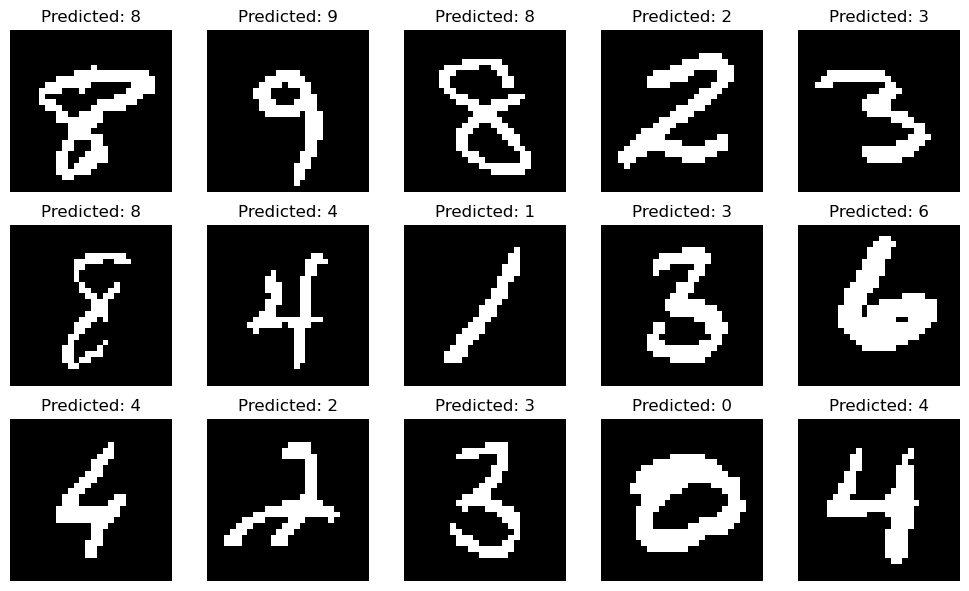

In [143]:
# Number of samples
num_samples = len(X_test_samples)
images_per_row = 5  # Max images per row
num_rows = int(np.ceil(num_samples / images_per_row))  # Calculate number of rows

# Create subplots grid
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

# Flatten axes if more than one row
axes = axes.flatten() if num_rows > 1 else [axes]

for i, ax in enumerate(axes):
    if i < num_samples:
        ax.imshow(X_test_samples[i].squeeze(), cmap='gray')  # Display image
        ax.set_title(f"Predicted: {df_output.loc[i, 'Predicted Value']}")
        ax.axis('off')  # Hide axis
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

###### End of the Notebook